In [1]:
import h5py
import pyBigWig
import matplotlib
from tqdm import tqdm
import scipy.ndimage
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
import math
import pandas as pd
import json 

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

In [2]:
file1= "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/bias_model/bias_predictions.h5"
bigwig="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/data/GM12878_unstranded.bw"
peaks="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/bias_model/filtered.peaks.bed"
nonpeaks="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/bias_model/filtered.bias_nonpeaks.bed"

chr_fold_path="/mnt/lab_data2/anusri/chrombpnet/splits/fold_0.json"
outf="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/bias_model/"


# Plotting

In [3]:
def density_scatter(x, y, xlab, ylab, ax = None, sort = True, bins = 20):
    """
    Scatter plot colored by 2d histogram
    """
    bad_indices=np.where(np.isnan(x))+np.where(np.isnan(y))
    x=x[~np.isin(np.arange(x.size),bad_indices)]
    y=y[~np.isin(np.arange(y.size),bad_indices)]

    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0
    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    #z = [plt.cm.viridis(t) for t in z]
    ax.scatter( x, y, c=z ,linewidths=0,edgecolors=None, rasterized=True)
    #ax.plot(x,y,'o',rasterized=True,linewidths=0,c=z)

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    return ax

# Main

In [4]:
data = h5py.File(file1)

mode="test"
splits_dict=json.load(open(chr_fold_path))
chroms_to_keep=splits_dict[mode]

# NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
# peaks_bed_regions=pd.read_csv(peaks,header=None,sep='\t',names=NARROWPEAK_SCHEMA)
# peaks_bed_regions_to_keep=peaks_bed_regions[peaks_bed_regions["chr"].isin(chroms_to_keep)]

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
nonpeaks_bed_regions=pd.read_csv(nonpeaks,header=None,sep='\t',names=NARROWPEAK_SCHEMA)
nonpeaks_bed_regions_to_keep=nonpeaks_bed_regions[nonpeaks_bed_regions["chr"].isin(chroms_to_keep)]


profile_predictions = data["predictions"]["logcounts"].value
prof_coords_chr = data["coords"]["coords_chrom"].value
prof_coords_center = data["coords"]["coords_center"].value
prof_coords_peak = data["coords"]["coords_peak"].value
print(profile_predictions.shape)

/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


(62929,)


/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  app.launch_new_instance()
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


In [5]:
bw = pyBigWig.open(bigwig) 

true_counts_mat_peaks = []
true_counts_mat_peaks_non_peaks = []

idx=0
for jdx in tqdm(range(prof_coords_chr.shape[0])):
        if prof_coords_peak[jdx] == 0:
                chr1 = nonpeaks_bed_regions_to_keep.iloc[idx, 0]
                start = nonpeaks_bed_regions_to_keep.iloc[idx, 1] + nonpeaks_bed_regions_to_keep.iloc[idx, -1] - 500
                end  =  nonpeaks_bed_regions_to_keep.iloc[idx, 1] + nonpeaks_bed_regions_to_keep.iloc[idx, -1] + 500

                true_counts = np.nan_to_num(bw.values(chr1,start,end ))
                true_counts_mat_peaks_non_peaks.append(np.log(np.sum(true_counts)+1))
                
                idx += 1
                continue

        chr1 = peaks_bed_regions_to_keep.iloc[jdx, 0]
        start = peaks_bed_regions_to_keep.iloc[jdx, 1] + peaks_bed_regions_to_keep.iloc[jdx, -1] - 500
        end  =  peaks_bed_regions_to_keep.iloc[jdx, 1] + peaks_bed_regions_to_keep.iloc[jdx, -1] + 500

        true_counts = np.nan_to_num(bw.values(chr1,start,end ))
        true_counts_mat_peaks.append(np.log(np.sum(true_counts)+1))
        #true_counts_mat_peaks_non_peaks.append(np.log(np.sum(true_counts)+1))
        

100%|██████████| 62929/62929 [00:34<00:00, 1842.69it/s]


In [7]:
# import scipy.stats
# cta = scipy.stats.pearsonr(true_counts_mat_peaks,profile_predictions[prof_coords_peak==1])
# print(cta[1])
#peaks_bed_regions_to_keep

In [8]:
# plt.rcParams["figure.figsize"]=8,8
# fig=plt.figure() 
# density_scatter(np.array(true_counts_mat_peaks),
#                 profile_predictions[prof_coords_peak==1],
#                 xlab='Log Count Labels',
#                 ylab='Log Count Predictions')

#plt.savefig(outf + "/K562.scatter.plot.peaks.pdf",format='pdf',dpi=300, transparent=True)
# plt.savefig("subfigs/performance_plots/K562.scatter.plot.peaks.pdf",format='pdf',dpi=300, transparent=True)


In [9]:
len(true_counts_mat_peaks_non_peaks)

62929

In [10]:
nonpeaks_bed_regions_to_keep.shape

(62929, 10)

In [12]:
#peaks_bed_regions_to_keep.shape

<Figure size 576x576 with 0 Axes>

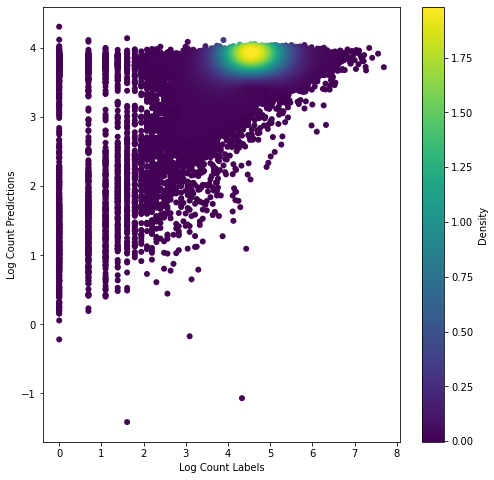

In [13]:
plt.rcParams["figure.figsize"]=8,8
fig=plt.figure() 
density_scatter(np.array(true_counts_mat_peaks_non_peaks),
                profile_predictions[prof_coords_peak==0],
                xlab='Log Count Labels',
                ylab='Log Count Predictions')

#plt.savefig(outf + "/K562.scatter.plot.peaks.nonpeaks.pdf",format='pdf',dpi=300, transparent=True)
plt.savefig("subfigs/performance_plots/gm12878.bias.scatter.plot.nonpeaks.pdf",format='pdf',dpi=300, transparent=True)


In [14]:
import scipy.stats
cta = scipy.stats.pearsonr(true_counts_mat_peaks_non_peaks,profile_predictions[prof_coords_peak==0])
print(cta)

(0.6046357361003393, 0.0)


/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


(62929, 10)
         chr      start        end  1  2  3  4  5  6  summit
203835  chr3  105204000  105206114  .  .  .  .  .  .    1057
203836  chr3  146462000  146464114  .  .  .  .  .  .    1057
203837  chr1   77114000   77116114  .  .  .  .  .  .    1057
203838  chr1  116329000  116331114  .  .  .  .  .  .    1057
203839  chr1  240701000  240703114  .  .  .  .  .  .    1057


/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  0%|          | 0/62929 [00:00<?, ?it/s]/users/anusri/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1290: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=axis, keepdims=True)
/users/anusri/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1291: RuntimeWarning: invalid value encountere

0.736680850357897
0.9641373698960791
nan


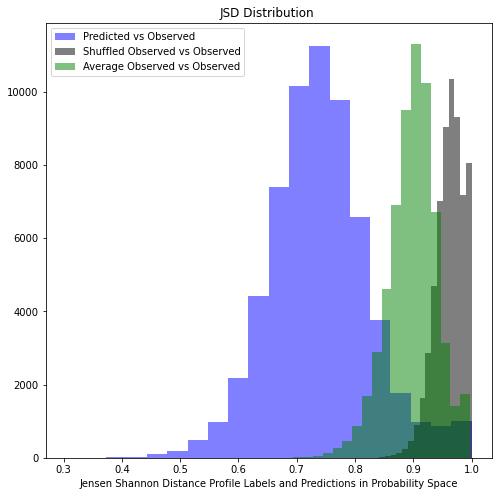

In [15]:
import h5py
import pyBigWig
import matplotlib
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
import scipy.ndimage
import json

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


bigwig="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/data/GM12878_unstranded.bw"
data = h5py.File(file1)

import pandas as pd

peaks=nonpeaks
chr_fold_path="/mnt/lab_data2/anusri/chrombpnet/splits/fold_0.json"

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
bed_regions=pd.read_csv(peaks,header=None,sep='\t',names=NARROWPEAK_SCHEMA)
mode="test"
splits_dict=json.load(open(chr_fold_path))
chroms_to_keep=splits_dict[mode]

bed_regions_to_keep=bed_regions[bed_regions["chr"].isin(chroms_to_keep)]
print(bed_regions_to_keep.shape)
print(bed_regions_to_keep.head())



profile_predictions = data["predictions"]["profs"].value
prof_coords_chr = data["coords"]["coords_chrom"].value
prof_coords_center = data["coords"]["coords_center"].value
prof_coords_peak = data["coords"]["coords_peak"].value
num_bins=20
plt.rcParams["figure.figsize"]=8,8


#print(prof_coords_chr.shape)
jsd_pw=[]
jsd_rnd=[]
jsd_rep=[]
jsd_ml=[]

jdx=0
bw = pyBigWig.open(bigwig) 
pseudocount=0.001

true_counts_mat = []
rep1_counts_mat = []
rep2_counts_mat = []
for idx in tqdm(range(prof_coords_chr.shape[0])):
	if prof_coords_peak[idx] == 1:
		continue

	chr1 = bed_regions_to_keep.iloc[jdx, 0]
	start = bed_regions_to_keep.iloc[jdx, 1] + bed_regions_to_keep.iloc[jdx, -1] - 500
	end  =  bed_regions_to_keep.iloc[jdx, 1] + bed_regions_to_keep.iloc[jdx, -1] + 500

    
	true_counts = np.nan_to_num(bw.values(chr1,start,end ))

# 	if sum(true_counts) == 0:
# 		continue
        
	true_counts_mat.append(true_counts)

# 	rep1_counts_mat.append(np.nan_to_num(rep1.values(chr,start,end ))+pseudocount)
# 	rep2_counts_mat.append(np.nan_to_num(rep2.values(chr,start,end ))+pseudocount)

	jdx+=1


mean_profile_label=np.nanmean(true_counts_mat,axis=0)

jdx=0
for idx in tqdm(range(prof_coords_chr.shape[0])):
	if prof_coords_peak[idx] == 1:
		continue

	true_counts =  true_counts_mat[jdx]

# 	if sum(true_counts) == 0:
# 		continue


	shuffled_labels=np.random.permutation(true_counts)
	pred_probs = profile_predictions[idx]


	#true_counts = scipy.ndimage.gaussian_filter1d(true_counts, 7,axis=0, truncate=(80 / 14))
	#pred_probs = scipy.ndimage.gaussian_filter1d(pred_probs, 7,axis=0, truncate=(80 / 14))

	cur_jsd=jensenshannon(true_counts/(np.nansum(true_counts)+pseudocount),pred_probs, base=2)
	jsd_pw.append(cur_jsd)

# 	rep1_counts = rep1_counts_mat[jdx]
# 	rep2_counts = rep2_counts_mat[jdx]

	mean_profile_label_prob=mean_profile_label/(np.nansum(mean_profile_label)+pseudocount)

	cur_mean_lbl=jensenshannon(true_counts/(np.nansum(true_counts)+pseudocount),mean_profile_label_prob, base=2)
	jsd_ml.append(cur_mean_lbl)


	#plt.figure()
	#plt.plot(true_counts/(np.nansum(true_counts)))
	#plt.plot(pred_probs)
	#plt.show()

	#shuffled_labels = scipy.ndimage.gaussian_filter1d(shuffled_labels, 7,axis=0, truncate=(80 / 14))
	shuffled_labels_prob=shuffled_labels/(np.nansum(shuffled_labels)+pseudocount)


# 	rep1_counts = scipy.ndimage.gaussian_filter1d(rep1_counts, 7,axis=0, truncate=(80 / 14))
# 	rep2_counts = scipy.ndimage.gaussian_filter1d(rep2_counts, 7,axis=0, truncate=(80 / 14))
	curr_jsd_rnd=jensenshannon(true_counts/(np.nansum(true_counts)+pseudocount),shuffled_labels_prob, base=2)
	jsd_rnd.append(curr_jsd_rnd)

# 	rep_jsd=jensenshannon(rep1_counts/(np.nansum(rep1_counts)),rep2_counts/(np.nansum(rep2_counts)))
# 	jsd_rep.append(rep_jsd)

	jdx+=1



print(np.nanmedian(jsd_pw))
print(np.nanmedian(jsd_rnd))
print(np.nanmedian(jsd_rep))

#print(jsd_pw)
plt.figure()
n,bins,patches=plt.hist(jsd_pw,num_bins,facecolor='blue',alpha=0.5,label="Predicted vs Observed")
n1,bins1,patches1=plt.hist(jsd_rnd,num_bins,facecolor='black',alpha=0.5,label='Shuffled Observed vs Observed')
n1,bins1,patches1=plt.hist(jsd_ml,num_bins,facecolor='green',alpha=0.5,label='Average Observed vs Observed')
# n1,bins1,patches1=plt.hist(jsd_rep,num_bins,facecolor='red',alpha=0.5,label='Pseudoreplicate performance')
plt.xlabel('Jensen Shannon Distance Profile Labels and Predictions in Probability Space')
plt.title("JSD Distribution ")
plt.legend(loc='best')
# plt.savefig("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/nautilus_runs/K562_02.17.2022_bias_128_4_1234_0.5_fold_0/chrombpnet_model/K562.smooth.jsd.pdf",format='pdf',dpi=300, transparent=True)



/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterize" which is no longer supported as of 3.3 and will become an error in 3.6
  # This is added back by InteractiveShellApp.init_path()


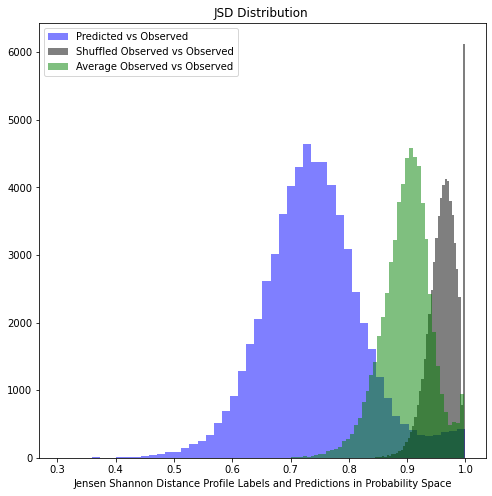

In [16]:
num_bins=50
#print(jsd_pw)
plt.figure()
n,bins,patches=plt.hist(jsd_pw,num_bins,facecolor='blue',alpha=0.5,label="Predicted vs Observed")
n1,bins1,patches1=plt.hist(jsd_rnd,num_bins,facecolor='black',alpha=0.5,label='Shuffled Observed vs Observed')
n1,bins1,patches1=plt.hist(jsd_ml,num_bins,facecolor='green',alpha=0.5,label='Average Observed vs Observed')
# n1,bins1,patches1=plt.hist(jsd_rep,num_bins,facecolor='red',alpha=0.5,label='Pseudoreplicate performance')
plt.xlabel('Jensen Shannon Distance Profile Labels and Predictions in Probability Space')
plt.title("JSD Distribution ")
plt.legend(loc='best')
plt.savefig("gm12878.bias.jsd.pdf",format='pdf',dpi=300, transparent=True, rasterize=True)

# plt.savefig("/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/nautilus_runs/K562_02.17.2022_bias_128_4_1234_0.5_fold_0/chrombpnet_model/K562.smooth.jsd.pdf",format='pdf',dpi=300, transparent=True)



In [17]:
np.median(jsd_pw)

nan